# Image Preprocessing for Sheep Detection

In [ ]:
%pip install opencv-python numpy matplotlib pillow piexif

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import piexif
import os
import cv2

# Loading the images

The JPEG images are in the BGR format. For the preprocessing techniques to be applied the images need to be loaded in as Grayscale images.

In [ ]:
def load_image(path: str) -> np.ndarray:
    """Load an image in grayscale from a file path."""
    image = cv2.imread(path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

When you display an image with matplotlib it shows you also the extra noise more clearly but this is not what the output is. So this function you can toggle what you do want to see the clear noise or the output.

In [22]:
def plot_images(images: list, normalize: bool = False):
    """
    Visually display images using matplotlib.
    
    Parameters:
        normalize (bool): If True, sets vmin/vmax to show noise more clearly.
    """
    fig, axes = plt.subplots(1, len(images), figsize=(10 * len(images), 10))

    if len(images) == 1:
        axes = [axes]

    for ax, image, idx in zip(axes, images, range(1, len(images) + 1)):
        if normalize:
            ax.imshow(image, cmap='gray', vmin=0, vmax=255)
        else:
            ax.imshow(image, cmap='gray')
        ax.set_title(f'Image {idx}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [15]:
ROOT_FOLDER = ".."
DATASET_FOLDER = f"{ROOT_FOLDER}/dataset"
ORIGINAL_IMAGE_FOLDER = f"{DATASET_FOLDER}/images/original"
ENHANCED_IMAGE_FOLDER = f"{DATASET_FOLDER}/images/enhanced"

example_images = [
    'DJI_20240125160526_0002_T.JPG',
    'DJI_20240125160538_0008_T.JPG', 
    'DJI_20240125160618_0028_T.JPG', 
    'DJI_20240125160820_0089_T.JPG',
    'DJI_20240125160808_0083_T.JPG'
]

# Preprocessing

Now before starting with the preprocessing techniques lets first look at the current images. When you let matplotlib show the extra noise you can really see that there is a difference in image quality and lightning.

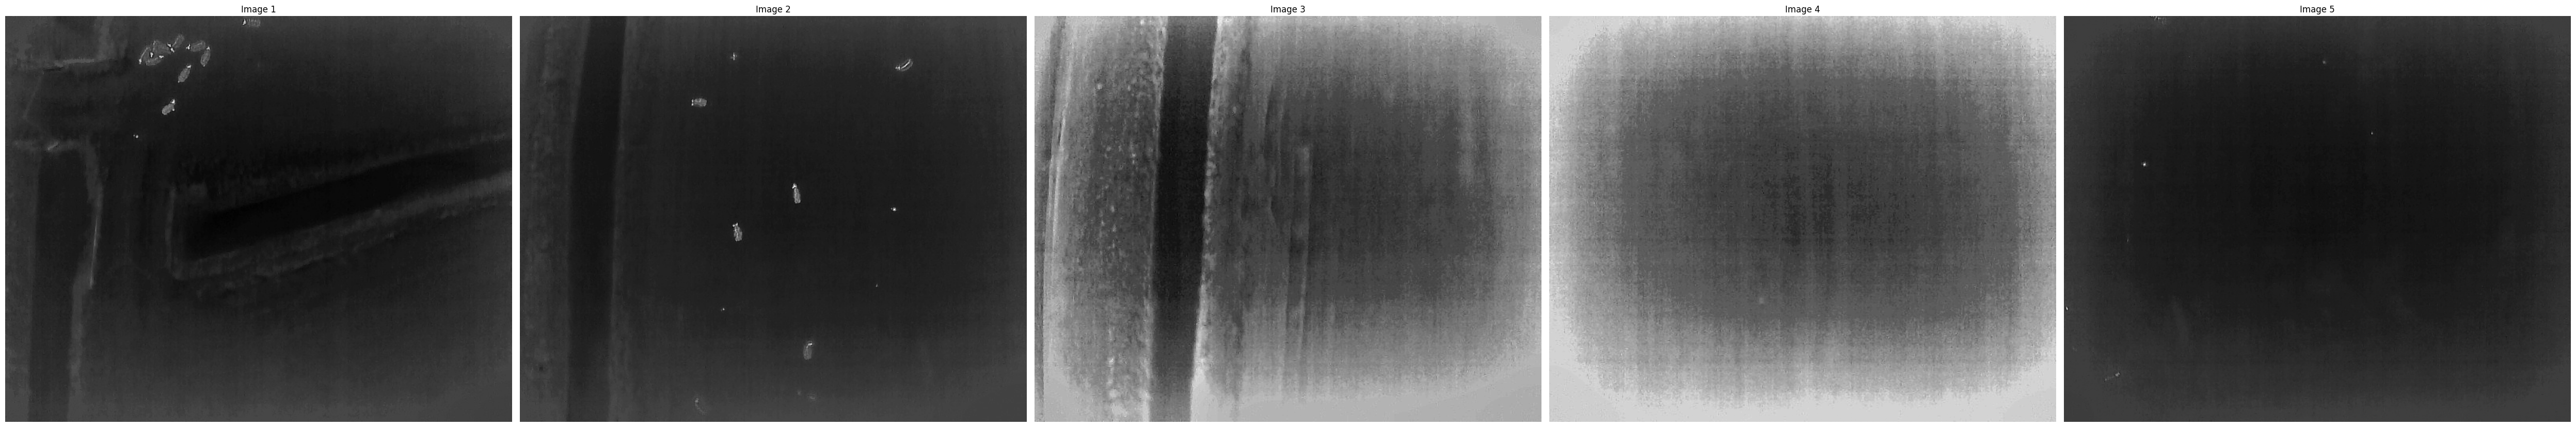

In [26]:

gray_images = [load_image(f'{ORIGINAL_IMAGE_FOLDER}/{img_name}') for img_name in example_images]
plot_images(gray_images, normalize=False)

In [10]:
img = Image.open(f"{ORIGINAL_IMAGE_FOLDER}/{example_images[0]}")
exif_data = piexif.load(img.info.get("exif", b""))
datetime_original = exif_data["Exif"][piexif.ExifIFD.DateTimeOriginal]

datetime_original = datetime_original.decode("utf-8")
print(f"Original DateTime: {datetime_original}")

Original DateTime: 2024:01:25 16:05:26


If you look at the time the image was taken you can see that this is not taken by night or in the dark. So problaby what happended they converted these images into grayscale 'infrared' to mimick infrared images.

## Remove Vignette

When you look at these images you can see that the middle of the image is mutch clearer than the rest. It has like a border of distorting noise this is problaby caused by the cameralens and enhanced by converting the color images to grayscale.

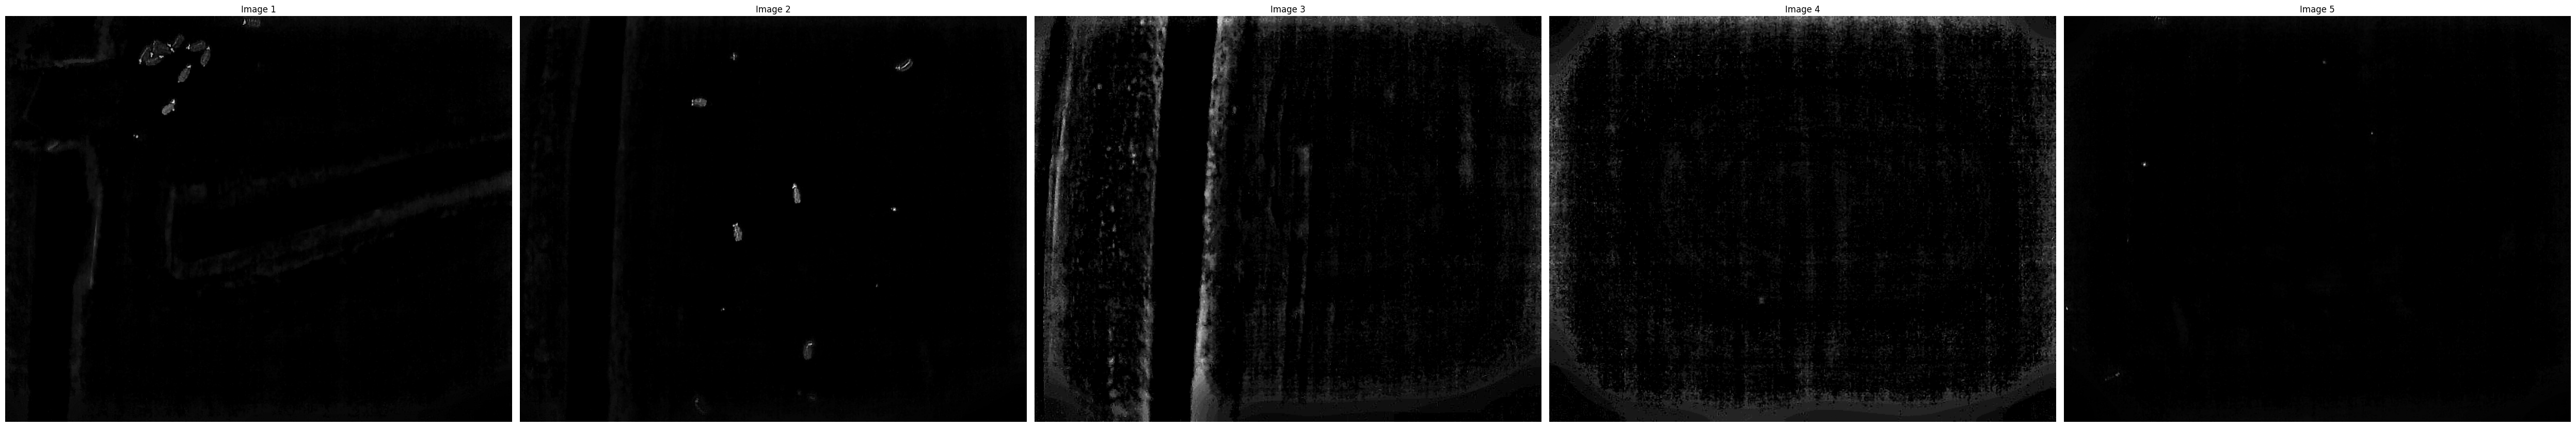

In [28]:
def remove_vignette(img: np.ndarray) -> np.ndarray:
    """Correct vignetting by subtracting a blurred version of the image (remove uneven illumination)."""
    # Create a very blurred version of the image to approximate lighting falloff
    background = cv2.GaussianBlur(img, (201, 201), 0)
    # Subtract the background lighting from the original image
    corrected = cv2.subtract(img, background)
    return corrected


images_without_vignette = [remove_vignette(img) for img in gray_images]
plot_images(images_without_vignette)

## Remove Noise

The images still have like a little noise when you zoom in so to counterfit this i tried to remove the noise.

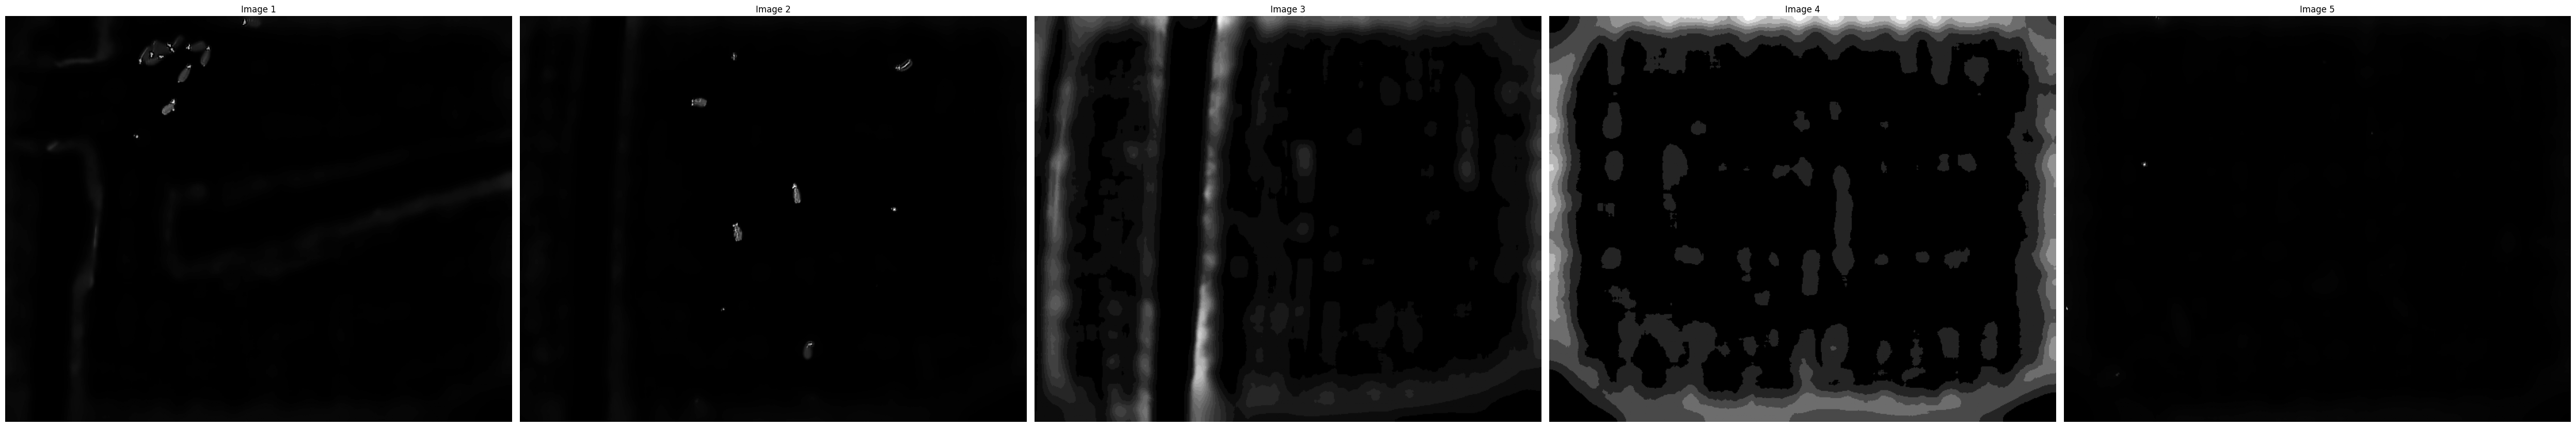

In [29]:
def remove_noise(img: np.ndarray) -> np.ndarray:
    """Apply noise reduction using Non-local Means Denoising."""
    # h=10 is the filter strength for the noise removal; adjust as needed for balance between noise and detail
    denoised = cv2.fastNlMeansDenoising(img, h=10)
    return denoised

images_without_noise = [remove_noise(img) for img in images_without_vignette]
plot_images(images_without_noise)

When i you look at these images it looks like the techniques i applied is making the images without any sheep worse. This is not the case if you normalize the image you can see the image which is saved.

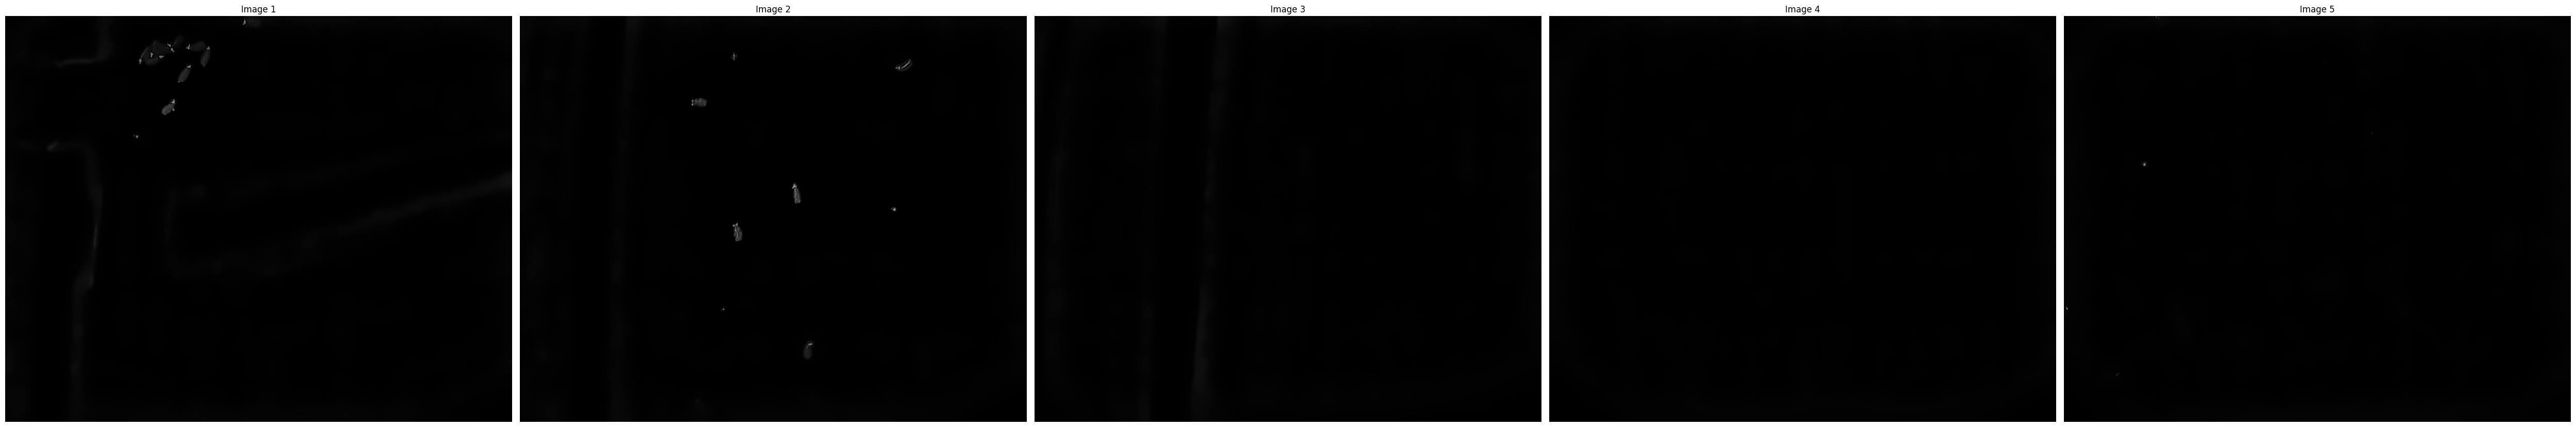

In [33]:
plot_images(images_without_noise, normalize=True)

## Enhance detail

Now you can really see the noise removal and the vignette removal had an effect. But with this noise removal there could be some details about the sheep which are lost. So to enhance the details of the sheep CLAHE can be applied.

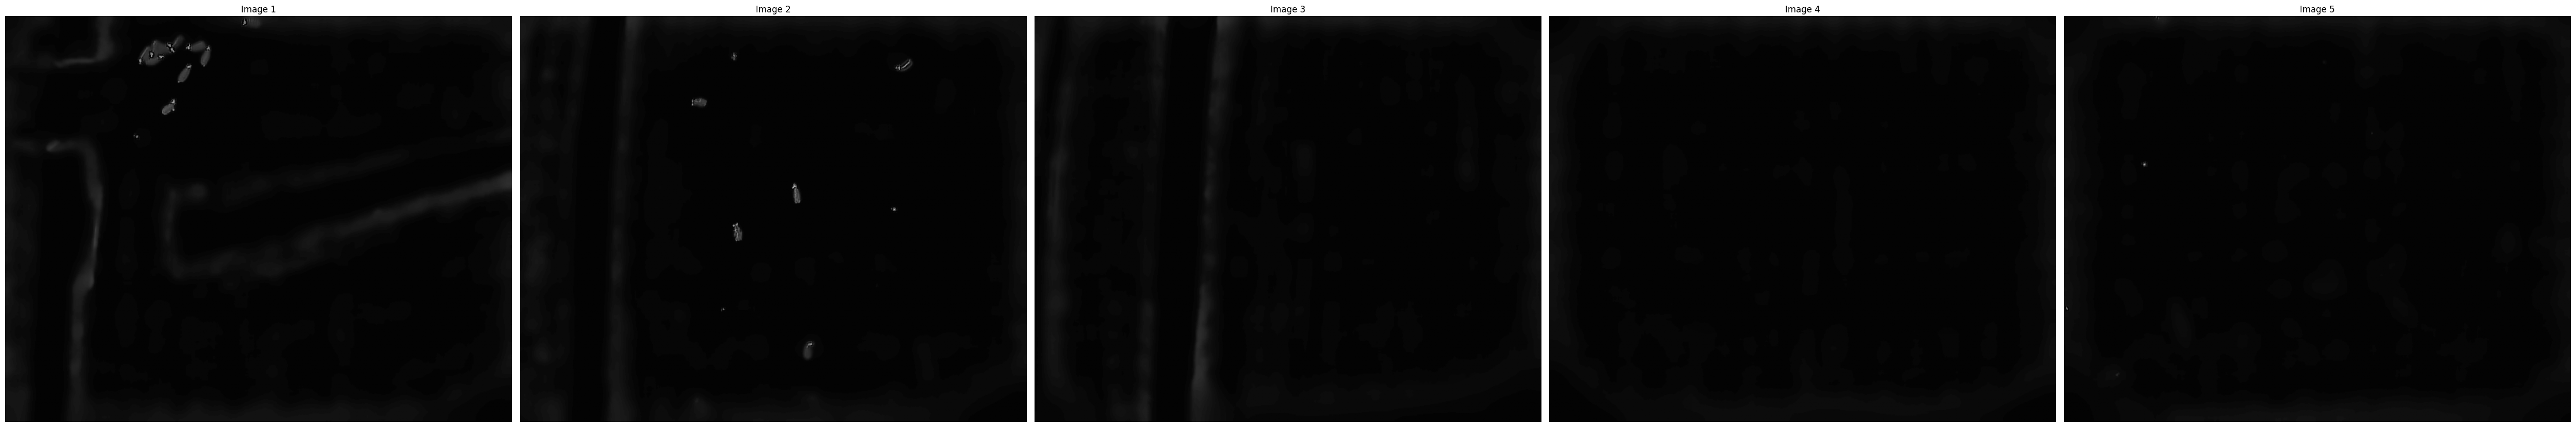

In [34]:
def apply_clahe(img: np.ndarray) -> np.ndarray:
    """Boost local contrast using CLAHE (optional; can introduce noise)."""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

    
clahe_images = [apply_clahe(img) for img in images_without_noise]
plot_images(clahe_images, normalize=True)

# Save images

In [35]:
def enhance_image(path: str) -> np.ndarray:
    """Apply the full enhancement pipeline to an image file path."""
    gray = load_image(path)
    corrected = remove_vignette(gray)
    denoised = remove_noise(corrected)
    return apply_clahe(denoised)

In [ ]:
os.makedirs(ENHANCED_IMAGE_FOLDER, exist_ok=True)

# Process each image in the dataset
for image_name in os.listdir(ORIGINAL_IMAGE_FOLDER):
    input_path = os.path.join(ORIGINAL_IMAGE_FOLDER, image_name)
    output_path = os.path.join(ENHANCED_IMAGE_FOLDER, image_name)
    try:
        processed = enhance_image(input_path)
        # Save the enhanced image. Convert back to 3-channel BGR so it can be saved as color (optional).
        cv2.imwrite(output_path, cv2.cvtColor(processed, cv2.COLOR_GRAY2BGR))
    except Exception as e:
        print(f"Skipping {image_name}: {e}")